<a href="https://colab.research.google.com/github/Joe-Ol/NLP/blob/main/Twitter/topic_modelling_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Intros*

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import re

You can find the used data as well as more info on it here: [How-ISIS-Uses-Twitter](https://www.kaggle.com/fifthtribe/how-isis-uses-twitter)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/How ISIS Uses Twitter/tweets.csv')

In [3]:
for col in df.columns:
    print(col)

name
username
description
location
followers
numberstatuses
time
tweets


In [4]:
df.drop(['description', 'followers', 'numberstatuses', 'time', 'location'], axis=1, inplace=True)

# **Exploraotry Analysis**

In [5]:
len(df.username.unique())

112

In [6]:
len(df.tweets.unique())

17410

In [7]:
df

,name,username,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
...,...,...,...
17405,Anaksabil97,nvor85j,#Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17406,Anaksabil97,nvor85j,#Breaking\n\n Iraqi forces bulldozer destroyed...
17407,Anaksabil97,nvor85j,#Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408,Anaksabil97,nvor85j,#PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...


In [8]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

def find_links(tweet):
    return re.findall('(?:(?:https?|ftp|file):\/\/|www\.|ftp\.)(?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[-A-Z0-9+&@#\/%=~_|$?!:,.])*(?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[A-Z0-9+&@#\/%=~_|$])', tweet) 


In [9]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
#df['retweeted'] = df.tweets.apply(find_retweeted)
#df['mentioned'] = df.tweets.apply(find_mentioned)
df['hashtags'] = df.tweets.apply(find_hashtags)
df['link'] = df.tweets.apply(find_links)



---



Findingthe Most Popular Hashtags in Our Dataset

In [10]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [11]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [12]:
len(flattened_hashtags_df.hashtag.unique())

2309

In [13]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

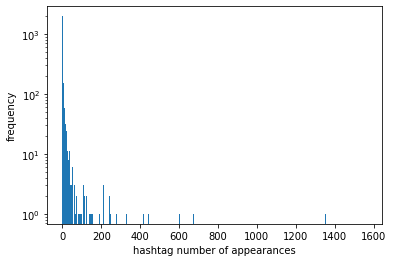

In [14]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

Finding the most common user

In [15]:
user_list_df = df.loc[
                       df.username.apply(
                           lambda username_list: username_list !=[]
                       ),['username']]

In [16]:
popular_users = user_list_df.groupby('username').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

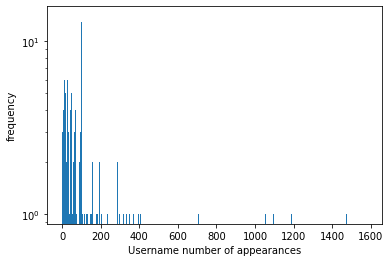

In [17]:
# number of times each user appears
counts = user_list_df.groupby(['username']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins_2 = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins_2)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('Username number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

Hashtags to Vectors

In [18]:
# take hashtags which appear at least this amount of times
min_appearance = 110
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [19]:
len(popular_hashtags_set)

25

In [20]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]


In [21]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [22]:
 hashtag_vector_df

,popular_hashtags,#Russia,#USA,#AmaqAgency,#Fallujah,#Turkey,#Iraq,#Breaking,#SAA,#Sinai,#Ramadi,#YPG,#Caliphate_News,#Aleppo,#BREAKING,#Syria,#Homs,#ISIS,#BreakingNews,#Libya,#Mosul,#US,#IS,#Assad,#IslamicState,#Palmyra
24,[#IS],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
30,[#BREAKING],0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
33,[#IS],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
44,"[#IS, #Syria, #Aleppo]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
65,[#IS],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17400,"[#Ramadi, #ISIS]",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17405,"[#Breaking, #IslamicState, #AmaqAgency]",0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17406,[#Breaking],0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17407,"[#Breaking, #AmaqAgency, #IslamicState]",0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [23]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

In [24]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

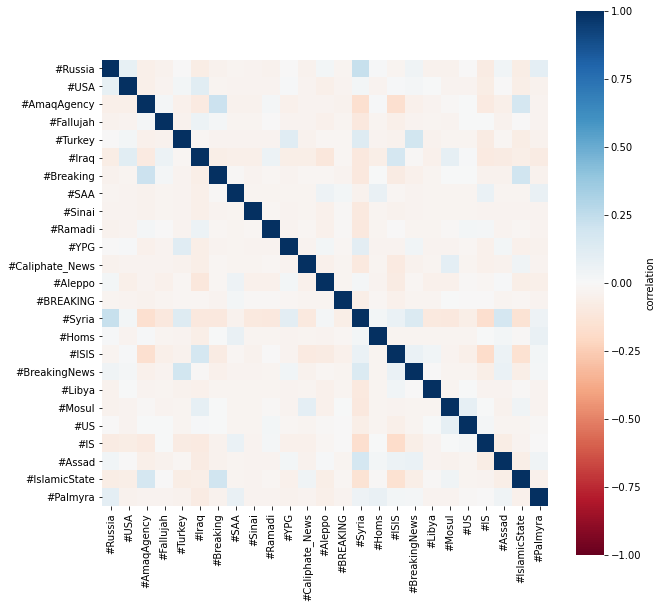

In [25]:
# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

# **Topic Modelling**

In [26]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [28]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [29]:
df['clean_tweet'] = df.tweets.apply(clean_tweet)

In [31]:
max_df = 0.9
min_df = 25

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [34]:
tf.shape

(17410, 1193)

In [37]:
hashtag_vector_df.shape

(4941, 26)

In [36]:
# tf_feature_names



---



Using LDA - *Latent Dirichlet Allocation* Algorithm

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [39]:
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [40]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [41]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,#syria,302.7,attack,403.6,de,435.1,#syria,1071.8,في,237.1,#is,522.6,al,686.3,islam,886.8,#amaqagency,303.5,allah,599.9
1,one,281.2,kill,366.6,le,355.1,#isis,1046.4,peopl,236.5,kill,419.7,isi,636.3,state,722.1,#islamicstate,276.6,muslim,288.4
2,today,232.3,…,278.3,news,307.0,#aleppo,283.3,like,234.3,armi,416.9,us,624.0,amp,199.2,fighter,250.6,may,265.7
3,n,205.9,al,259.1,la,227.1,armi,268.8,see,230.5,soldier,348.7,assad,453.3,#iraq,179.1,#breaking,236.9,know,223.0
4,fire,189.2,claim,225.3,un,195.4,report,267.9,…,219.9,al,301.6,fight,386.7,rt,169.4,oper,197.4,amp,216.6
5,civilian,159.6,#isis,161.1,est,170.1,kill,262.0,من,194.1,destroy,295.8,syrian,307.1,mosul,147.8,follow,174.8,…,193.6
6,airstrik,156.5,releas,145.3,#caliphate,167.1,amp,250.3,say,185.1,forc,278.2,rebel,266.0,new,144.2,amp,170.3,make,186.4
7,#russia,155.5,year,143.8,à,156.1,#iraq,242.0,said,165.5,#isis,264.8,kill,258.1,video,132.2,الله,127.9,use,180.9
8,children,137.1,i,140.0,il,151.1,n,218.1,never,154.1,near,224.4,syria,209.2,isi,132.1,kill,118.3,pleas,163.6
9,kill,132.2,explos,135.6,📷,149.9,#breakingnews,210.3,even,151.6,east,207.9,saudi,206.4,ypg,127.6,support,115.8,al,159.2


Note: If a word apeear in most topics with a higher weight, it may be a good idea to add it to our stopword list since it may not be adding too much meaning to our task.



---



Using LDA -  *Non-Negative Matrix Factorisation* Algorithm